# 2023 Lazard Data Science Technical Test
# Predicting stock returns using news headline and sentiment
## By Grace Yang

## The notebook continues on the preprocessed data and builds an encoder-decoder network for two tasks:

- Task1: predict this month's return
- Task2: predict next month's return

## Import packages and the already preprocessed dataset

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [3]:

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import os
from os import listdir
from os.path import isfile, join
import warnings
warnings.filterwarnings("ignore")
import torch
if torch.cuda.is_available():
    print('CUDA is available!')
else:
    print('CUDA is not available.')

In [36]:
data = pd.read_csv('drive/MyDrive/stock/combined.csv')
data.head()

,trail_12m_net_sales,trail_12m_eps,trail_12m_oper_margin,ev_to_t12m_ebitda,enterprise_value,best_pe_ratio,px_last,best_sales,best_eps,best_cur_ev_to_ebitda,...,assets,product,contract,partnership,general,monthly_return,monthly_return_f1,year,month,year_bin
0,1639.84,-1.180,-24.8902,NaN,27049.4,NaN,68.875,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.066787,-0.027223,2000,2,0
1,1920.08,-1.415,-28.7724,NaN,24591.3,NaN,67.000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-0.027223,-0.176299,2000,3,0
2,1920.08,-1.415,-28.7724,NaN,24591.3,NaN,55.188,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-0.176299,-0.124574,2000,4,0
3,1920.08,-1.415,-28.7724,NaN,24591.3,NaN,48.313,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-0.124574,-0.248380,2000,5,0
4,2183.58,-1.490,-28.4537,NaN,14147.1,NaN,36.313,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-0.248380,-0.170407,2000,6,0


## Train test split
- Split the entire dataset to train, validation and test set according to a ratio of (0.7, 0.15, 0.15).
- Since this is a time series problem, we split according to the time of the data to prevent leakage.

In [39]:


labels = ['monthly_return', 'monthly_return_f1']
df_sorted = data.sort_values(by=['year', 'month'])


train_size = 0.7
val_size = 0.15
test_size = 0.15

train_end_index = int(train_size * len(df_sorted))
val_end_index = int((train_size + val_size) * len(df_sorted))

train = df_sorted.iloc[:train_end_index]
val = df_sorted.iloc[train_end_index:val_end_index]
test = df_sorted.iloc[val_end_index:]


train.reset_index(inplace = True, drop = True)
val.reset_index(inplace = True, drop = True)
test.reset_index(inplace = True, drop = True)
print(train.shape)
print(val.shape)
print(test.shape)



(2189, 91)
(469, 91)
(470, 91)


## Impute and rescale
- Since the encoder-decoder model cannot process `nan`, we impute all `nan` in the dataset with the mean of that column. This assumption is subject to discussion. I also use minmax scalar to rescale the input columns.

In [9]:

def scale_and_impute(save = False):
  exclude = ['year', 'month', 'year_bin', 'monthly_return', 'monthly_return_f1']
  for i in train.columns:
      if(i not in exclude):
          scaler = MinMaxScaler()
          train[i]=scaler.fit_transform(train[i].values.reshape(-1, 1))
  for i in val.columns:
      if(i not in exclude):
          scaler = MinMaxScaler()
          val[i]=scaler.fit_transform(val[i].values.reshape(-1, 1))
  for i in test.columns:
      if(i not in exclude):
          scaler = MinMaxScaler()
          test[i]=scaler.fit_transform(test[i].values.reshape(-1, 1))



  imputer = SimpleImputer(strategy='mean')
  train_imputed = pd.DataFrame(imputer.fit_transform(train))
  train_imputed.columns = train.columns

  val_imputed = pd.DataFrame(imputer.fit_transform(val))
  val_imputed.columns = val.columns

  test_imputed = pd.DataFrame(imputer.fit_transform(test))
  test_imputed.columns = test.columns

  if save:
    train.to_csv('drive/MyDrive/stock/trian.csv')
    val.to_csv('drive/MyDrive/stock/valid.csv')
    test.to_csv('drive/MyDrive/stock/test.csv')

    train_imputed.to_csv('drive/MyDrive/stock/trian_imputed.csv', index = False)
    val_imputed.to_csv('drive/MyDrive/stock/valid_imputed.csv', index = False)
    test_imputed.to_csv('drive/MyDrive/stock/test_imputed.csv', index = False)
  return train_imputed, val_imputed, test_imputed

add overlap between train and validation, validation and test. drop year and month information

In [10]:
train_df = pd.read_csv('drive/MyDrive/stock/trian_imputed.csv')
validation_df = pd.read_csv('drive/MyDrive/stock/valid_imputed.csv')
test_df = pd.read_csv('drive/MyDrive/stock/test_imputed.csv')
validation_df=pd.concat([train_df[-9:],validation_df])
validation_df=validation_df.reset_index(drop=True)
test_df=pd.concat([validation_df[-9:],test_df])
test_df=validation_df.reset_index(drop=True)

train_df.drop(['year', 'month', 'year_bin'],axis=1,inplace=True)
validation_df.drop(['year', 'month', 'year_bin'],axis=1,inplace=True)
test_df.drop(['year', 'month', 'year_bin'],axis=1,inplace=True)



## Prepare dataset and dataloader
- prepare separately for the two tasks.

In [11]:
class dataprep(Dataset):
    def __init__(self, dataframe, mode):
        self.df=dataframe
        self.labels = ['monthly_return', 'monthly_return_f1']
        self.mode = mode
    def __len__(self):
        return self.df.shape[0]-10
    def __getitem__(self,idx):
        if (idx<self.df.shape[0]):
            X=torch.from_numpy(self.df.drop(self.labels,axis=1).iloc[idx:idx+10].values)
            target=torch.from_numpy(self.df[self.labels[self.mode]][idx:idx+9].values)
            y=torch.tensor([self.df[self.labels[self.mode]].iloc[idx+9]])
            return ({'X':X, 'targets': target, 'y': y})


def get_data_loaders(train_df, validation_df, test_df, mode):
    train_set=dataprep(train_df, mode)
    validation_set=dataprep(validation_df, mode)
    test_set=dataprep(test_df, mode)
    train_loader = DataLoader(train_set, batch_size=15, shuffle=True, drop_last=True)
    val_loader = DataLoader(validation_set, batch_size=1, shuffle=False, drop_last=True)
    test_loader = DataLoader(test_set, batch_size=1, shuffle=False, drop_last=True)
    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = get_data_loaders(train_df, validation_df, test_df, mode=0)
train_loader2, val_loader2, test_loader2 = get_data_loaders(train_df, validation_df, test_df, mode=1)


## construct the encoder class, decoder class, training loop, and evaluation loop.

In [15]:
class EncoderRNN(nn.Module):
    def __init__(self,encoder_input_size=86,encoder_hidden_size=64, time_steps=10):
        super(EncoderRNN,self).__init__()
        self.input_size=encoder_input_size
        #input_size=n
        self.hidden_size=encoder_hidden_size
        #hidden_size=1
        self.t_steps=time_steps
        #time_steps=10

        self.input_attention=nn.Linear(time_steps+encoder_hidden_size,1)
        self.rnn=nn.GRU(self.input_size, self.hidden_size)

    def forward(self,encoder_input,batch_size,hidden):
        #encoder_input:batch,T,n
        encoder_input=encoder_input.permute(0,2,1) #batch,n,T
        #print (encoder_input.size())
        #hidden=self.initHidden(batch_size) #hidden : 1,batch,hidden_size
        #print (hidden.size())
        encoded = torch.zeros(batch_size, self.t_steps, self.hidden_size,device=device) #encoded: 1,T,hidden_size
        #print(encoded.size())
        for t in range(self.t_steps):
            #print(hidden.repeat(self.input_size,1,1))
            x=torch.cat((hidden.repeat(self.input_size,1,1).permute(1,0,2),encoder_input),dim=2)
            #print (x.size())
            #x:batch,n,T+hidden_size
            x=x.view(-1,self.t_steps+self.hidden_size)
            #print (x.size())
            #x:batch*n,T+hidden_size
            x=F.softmax((self.input_attention(x)).view(-1,self.input_size),dim=1)
            #print (x.size())
            #print(encoder_input[:,t,:].size())
            #x:batch,n
            x=torch.mul(x,encoder_input[:,:,t])
            #print (x.size())
            #x:1,n
            output, hidden=self.rnn(x.unsqueeze(0), hidden)
            #print (output.size(), hidden.size())
            encoded[:,t,:]=hidden
            #output,hidden:1,1,hidden
        return encoded

    def initHidden(self,batch_size):
        return torch.zeros(1, batch_size, self.hidden_size, device=device)


In [16]:
class DecoderRNN(nn.Module):
    def __init__(self,decoder_hidden_size=64,encoder_hidden_size=64,decoder_input_size=1, time_steps=10):
        super(DecoderRNN,self).__init__()
        self.decoder_hidden_size=decoder_hidden_size
        self.encoder_hidden_size=encoder_hidden_size
        self.decoder_input_size=decoder_input_size
        self.t_steps=time_steps

        self.temporal_attention=nn.Linear(decoder_hidden_size+encoder_hidden_size, 1)
        self.rnn=nn.GRU(decoder_input_size,decoder_hidden_size)
        self.fc1 = nn.Linear(encoder_hidden_size + 1, 1)
        self.fc2 = nn.Linear(decoder_hidden_size + encoder_hidden_size, 1)

    def forward(self,encoded,y_history,batch_size,hidden):
        #encoded: batch,T,hidden_size
        #print (encoded.size())

        #y_history: batch,T-1
        #hidden=self.initHidden(batch_size) #hidden:1,batch,hidden_size
        #print (hidden.size())
        for t in range(self.t_steps):
            x=torch.cat((hidden.repeat(self.t_steps,1,1).permute(1,0,2), encoded), dim=2)
            #x:batch,T,enc_hidden_size+dec_hidden_size
            x=F.softmax(self.temporal_attention(x.view(-1,self.decoder_hidden_size+self.encoder_hidden_size)).view(-1,self.t_steps), dim=1)
            #x:batch,T
            x=torch.bmm(x.unsqueeze(1), encoded)[:,0,:]
            #x:batch,hidden_size
            if (t < self.t_steps-1):
                y_tilda=self.fc1(torch.cat((x, y_history[:, t].unsqueeze(1)), dim=1))
                output, hidden=self.rnn(y_tilda.unsqueeze(0), hidden)
        y_pred=self.fc2(torch.cat((hidden[0], x), dim = 1))

        return y_pred


    def initHidden(self,batch_size):
        return torch.zeros(1, batch_size, self.decoder_hidden_size, device=device)

In [23]:
def train(encoder,decoder,encoder_optimizer, decoder_optimizer, train_loader, loss_criterion, rl, num_epochs, epoch, epochs):
    running_loss=0
    for i, sample in enumerate(train_loader):
        x=Variable(sample['X'].type(torch.cuda.FloatTensor))

        y=Variable(sample['targets'].type(torch.cuda.FloatTensor))
        y_true=Variable(sample['y'].type(torch.cuda.FloatTensor))

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        hidden=encoder.initHidden(15)
        encoded=encoder(x,15,hidden)
        hidden=decoder.initHidden(15)
        y_pred=decoder(encoded,y,4,hidden)

        loss=loss_criterion(y_pred,y_true)
        running_loss+=loss.item()
        rl.append(loss.item())

        loss.backward()
        encoder_optimizer.step()
        decoder_optimizer.step()

    print('Epoch: {}/{} | Loss: {}'.format(epoch-epochs+1, num_epochs, running_loss))


In [24]:
def pp(y_pred,y_true):
  r2 = r2_score(y_true, y_pred)
  return r2

In [25]:
def evaluate(encoder,decoder, val_loader, loss_criterion, num_epochs, epoch, epochs):
    eval_loss=0
    y_predicted=[]
    y_actual=[]
    with torch.no_grad():
        for i,sample in enumerate(val_loader):
            x=sample['X'].type(torch.cuda.FloatTensor)
            y=sample['targets'].type(torch.cuda.FloatTensor)
            y_true=sample['y'].type(torch.cuda.FloatTensor)


            hidden=encoder.initHidden(1)
            encoded=encoder(x,1,hidden)
            hidden=decoder.initHidden(1)
            y_pred=decoder(encoded,y,1,hidden)

            loss=loss_criterion(y_pred,y_true)
            eval_loss+=loss.item()
            y_predicted.append(y_pred.item())
            y_actual.append(y_true.item())

        pred_perf=pp(y_predicted, y_actual)
    print('Epoch: {}/{} | Evaluation_Loss: {} | Pred. Power: {}'.format(epoch-epochs+1, num_epochs, eval_loss, pred_perf))
    if epoch %5 ==0:
      plt.plot(range(len(y_predicted)),y_predicted,color='red')
      plt.plot(range(len(y_actual)),y_actual,color='blue')
      #print(len(y_predicted),len(y_actual))
      plt.show()


    return eval_loss,pred_perf

In [ ]:


def train_valid_plot(train_dataloader, valid_dataloader, save_path):
  rl=[]
  num_epochs=50
  epochs=0
  eval_thresh = 5
  pred_perf_thresh = 0.1

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  encoder= EncoderRNN().cuda()
  decoder = DecoderRNN().cuda()
  encoder_optimizer = optim.Adam(encoder.parameters())
  decoder_optimizer = optim.Adam(decoder.parameters())
  criterion=nn.MSELoss()

  for epoch in range(epochs,epochs+num_epochs):
      train(encoder,decoder,encoder_optimizer, decoder_optimizer,train_dataloader,criterion,rl,num_epochs, epoch, epochs)
      eval_loss, pred_perf=evaluate(encoder,decoder, valid_dataloader, criterion, num_epochs, epoch, epochs)
      if((eval_loss<eval_thresh) and (pred_perf>pred_perf_thresh)):
        print ('%---Saving the model---%')
        torch.save({
            'epoch': epoch+1,
            'encoder_state_dict': encoder.state_dict(),
            'decoder_state_dict': decoder.state_dict(),
            'encoder_optimizer_state_dict': encoder_optimizer.state_dict(),
            'decoder_optimizer_state_dict': decoder_optimizer.state_dict(),
            'loss': rl,
            },f'drive/MyDrive/stock/models/stockPrice/{save_path}')
      if eval_loss < eval_thresh:
        eval_thresh = eval_loss
      if eval_loss < pred_perf_thresh:
        pred_perf_thresh = pred_perf

## Train Model1: monthly_return prediction model
- The model tends to over-fit as the training epoch increases.
- save the model that has the yet best evaluation loss and predictive power.
- visualize how the model fits to the training set as the training proceeds.

Epoch: 1/50 | Loss: 1.1251914156600833
Epoch: 1/50 | Evaluation_Loss: 3.905625884615585 | Pred. Power: 0.1278543350926853


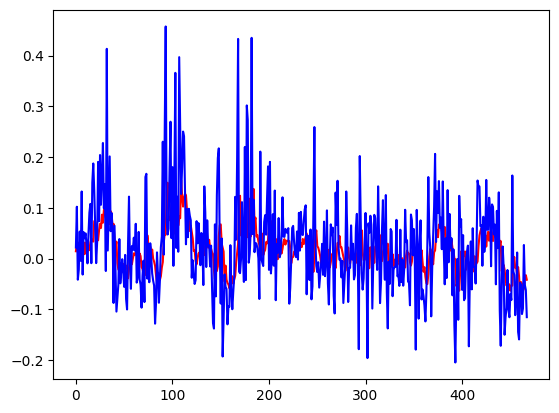

%---Saving the model---%
Epoch: 2/50 | Loss: 1.1226071793353185
Epoch: 2/50 | Evaluation_Loss: 3.939628204404423 | Pred. Power: 0.12026146035600793
Epoch: 3/50 | Loss: 1.1405090942280367
Epoch: 3/50 | Evaluation_Loss: 3.9020451878219653 | Pred. Power: 0.12865392086224392
%---Saving the model---%
Epoch: 4/50 | Loss: 1.125286332622636
Epoch: 4/50 | Evaluation_Loss: 3.939570433726601 | Pred. Power: 0.12027435575352041
Epoch: 5/50 | Loss: 1.1044674708973616
Epoch: 5/50 | Evaluation_Loss: 3.8708451440799987 | Pred. Power: 0.135621065548171
%---Saving the model---%
Epoch: 6/50 | Loss: 1.1196876427857205
Epoch: 6/50 | Evaluation_Loss: 3.896366670458162 | Pred. Power: 0.12992198248648723


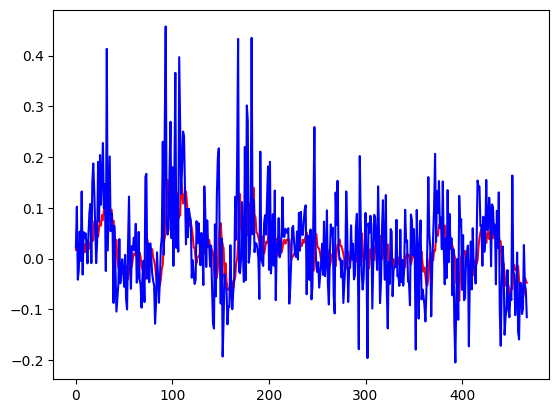

Epoch: 7/50 | Loss: 1.1233802101342008
Epoch: 7/50 | Evaluation_Loss: 3.9278664194279784 | Pred. Power: 0.12288792878761845
Epoch: 8/50 | Loss: 1.1142201920738444
Epoch: 8/50 | Evaluation_Loss: 4.001425851869097 | Pred. Power: 0.10646174493893934
Epoch: 9/50 | Loss: 1.1046509084990248
Epoch: 9/50 | Evaluation_Loss: 4.0104770603139315 | Pred. Power: 0.10444056212340758
Epoch: 10/50 | Loss: 1.0973564632586204
Epoch: 10/50 | Evaluation_Loss: 4.083329017432856 | Pred. Power: 0.08817236031235764
Epoch: 11/50 | Loss: 1.0882990711834282
Epoch: 11/50 | Evaluation_Loss: 4.252491987161571 | Pred. Power: 0.050397412538471076


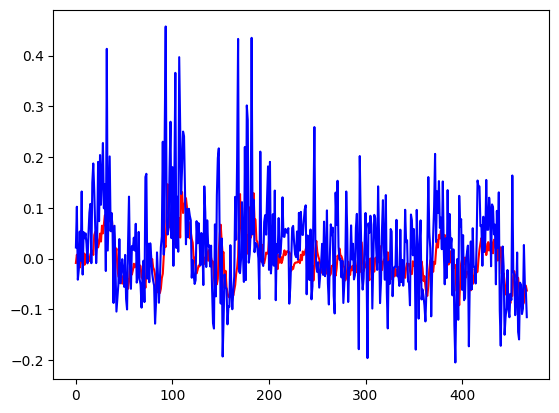

Epoch: 12/50 | Loss: 1.1001849513268098
Epoch: 12/50 | Evaluation_Loss: 4.338914246536339 | Pred. Power: 0.031098899611394448
Epoch: 13/50 | Loss: 1.0924588608322665
Epoch: 13/50 | Evaluation_Loss: 4.096968093332592 | Pred. Power: 0.08512667136996033
Epoch: 14/50 | Loss: 1.0956615480827168
Epoch: 14/50 | Evaluation_Loss: 3.894303480082357 | Pred. Power: 0.13038269490987653
Epoch: 15/50 | Loss: 1.071896769135492
Epoch: 15/50 | Evaluation_Loss: 4.123928295790092 | Pred. Power: 0.0791063267262283
Epoch: 16/50 | Loss: 1.0681707257172093
Epoch: 16/50 | Evaluation_Loss: 3.931982457613974 | Pred. Power: 0.12196879091514001


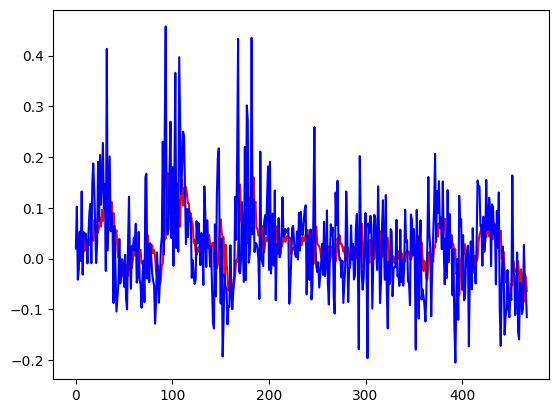

Epoch: 17/50 | Loss: 1.0656815091497265
Epoch: 17/50 | Evaluation_Loss: 4.053840847267384 | Pred. Power: 0.09475721254438141
Epoch: 18/50 | Loss: 1.0575543494196609
Epoch: 18/50 | Evaluation_Loss: 3.897760317396969 | Pred. Power: 0.129610766618534
Epoch: 19/50 | Loss: 1.050606615259312
Epoch: 19/50 | Evaluation_Loss: 3.913064666381615 | Pred. Power: 0.12619322919213716
Epoch: 20/50 | Loss: 1.0391397211933509
Epoch: 20/50 | Evaluation_Loss: 4.001680680245688 | Pred. Power: 0.10640482797310735
Epoch: 21/50 | Loss: 1.0411752843065187
Epoch: 21/50 | Evaluation_Loss: 3.983950559056969 | Pred. Power: 0.11036405242361358


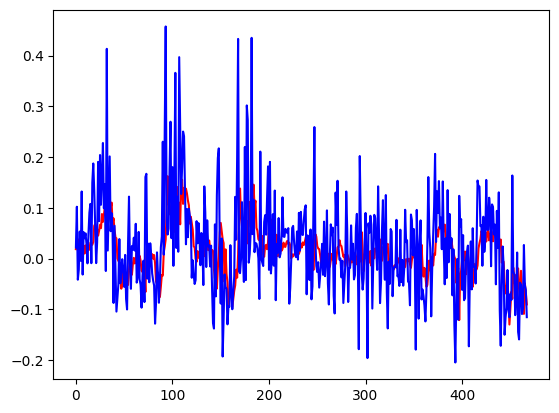

Epoch: 22/50 | Loss: 1.0378403951763175
Epoch: 22/50 | Evaluation_Loss: 3.9705277857309973 | Pred. Power: 0.11336142657337889
Epoch: 23/50 | Loss: 1.030591290909797
Epoch: 23/50 | Evaluation_Loss: 4.3421077915868205 | Pred. Power: 0.03038576322157327
Epoch: 24/50 | Loss: 1.0200743429595605
Epoch: 24/50 | Evaluation_Loss: 4.292906847791912 | Pred. Power: 0.041372578822481354
Epoch: 25/50 | Loss: 1.0119208168471232
Epoch: 25/50 | Evaluation_Loss: 3.9599351666641684 | Pred. Power: 0.1157268092838677
Epoch: 26/50 | Loss: 1.0259057005750947
Epoch: 26/50 | Evaluation_Loss: 3.910710845646226 | Pred. Power: 0.12671884529613975


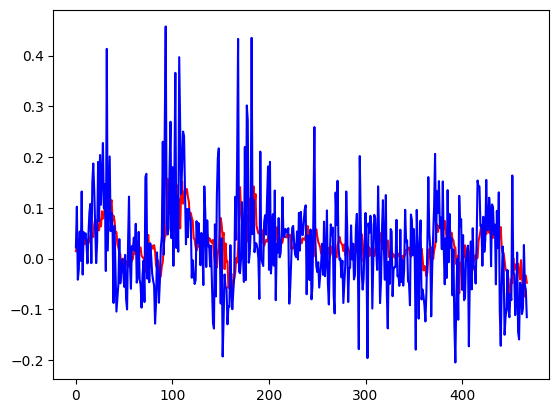

Epoch: 27/50 | Loss: 1.0036889018956572
Epoch: 27/50 | Evaluation_Loss: 3.962507475523374 | Pred. Power: 0.11515239368635322
Epoch: 28/50 | Loss: 0.9925482645630836
Epoch: 28/50 | Evaluation_Loss: 4.009632583619565 | Pred. Power: 0.10462912630920995
Epoch: 29/50 | Loss: 1.0053504168754444
Epoch: 29/50 | Evaluation_Loss: 4.066962400273525 | Pred. Power: 0.09182709995230764
Epoch: 30/50 | Loss: 0.9896491325926036
Epoch: 30/50 | Evaluation_Loss: 4.119643517382073 | Pred. Power: 0.08006315382346185
Epoch: 31/50 | Loss: 0.9761770634213462
Epoch: 31/50 | Evaluation_Loss: 4.119011215131495 | Pred. Power: 0.08020435089235489


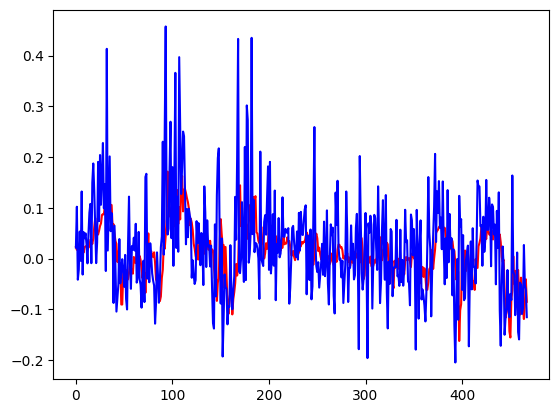

Epoch: 32/50 | Loss: 0.9720760042546317
Epoch: 32/50 | Evaluation_Loss: 4.173559851899757 | Pred. Power: 0.06802336942070308
Epoch: 33/50 | Loss: 0.9685698541579768
Epoch: 33/50 | Evaluation_Loss: 4.0661152435559735 | Pred. Power: 0.0920162754460413
Epoch: 34/50 | Loss: 0.9727598590543494
Epoch: 34/50 | Evaluation_Loss: 4.0354234308089545 | Pred. Power: 0.09886989842759553
Epoch: 35/50 | Loss: 0.9679740975843742
Epoch: 35/50 | Evaluation_Loss: 4.221220851769564 | Pred. Power: 0.05738042437470159
Epoch: 36/50 | Loss: 0.9643265818012878
Epoch: 36/50 | Evaluation_Loss: 4.263253507675346 | Pred. Power: 0.047994312193883726


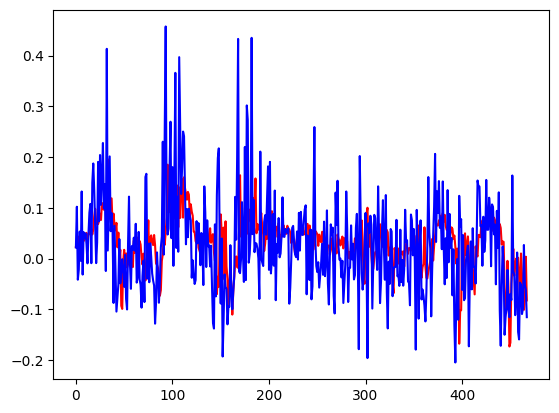

Epoch: 37/50 | Loss: 0.9656838328810409
Epoch: 37/50 | Evaluation_Loss: 4.100546317482994 | Pred. Power: 0.08432764350456279
Epoch: 38/50 | Loss: 0.9698770917602815
Epoch: 38/50 | Evaluation_Loss: 4.1504194136492245 | Pred. Power: 0.0731907316492455
Epoch: 39/50 | Loss: 0.9509152770042419
Epoch: 39/50 | Evaluation_Loss: 4.664312400505672 | Pred. Power: -0.04156411352561107
Epoch: 40/50 | Loss: 0.9504953896394
Epoch: 40/50 | Evaluation_Loss: 4.311677337076169 | Pred. Power: 0.03718103454076516
Epoch: 41/50 | Loss: 0.9487088603200391
Epoch: 41/50 | Evaluation_Loss: 4.225228871351943 | Pred. Power: 0.05648541267195306


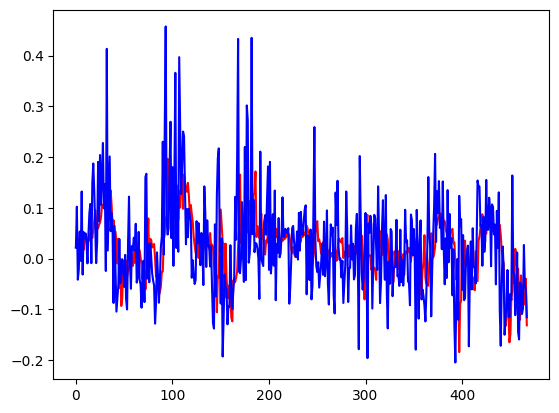

Epoch: 42/50 | Loss: 0.9285192643292248
Epoch: 42/50 | Evaluation_Loss: 4.475455823934869 | Pred. Power: 0.0006084943105132412
Epoch: 43/50 | Loss: 0.9491617717430927
Epoch: 43/50 | Evaluation_Loss: 4.491275084807904 | Pred. Power: -0.0029240346310017706
Epoch: 44/50 | Loss: 0.9285739791812375
Epoch: 44/50 | Evaluation_Loss: 4.682309982421317 | Pred. Power: -0.045583072069230735
Epoch: 45/50 | Loss: 0.9202752649434842
Epoch: 45/50 | Evaluation_Loss: 5.091885563352889 | Pred. Power: -0.1370433309943495
Epoch: 46/50 | Loss: 0.9156214929535054
Epoch: 46/50 | Evaluation_Loss: 4.485257108190702 | Pred. Power: -0.0015801902169847448


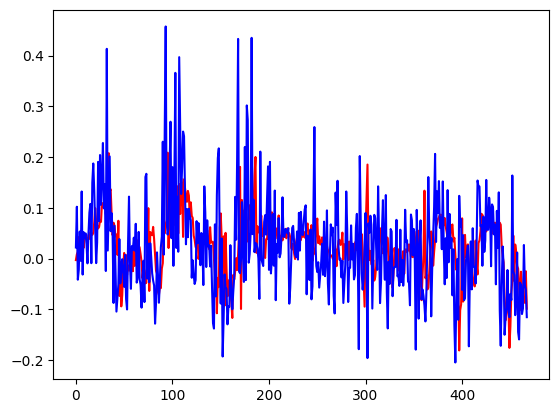

Epoch: 47/50 | Loss: 0.9079937256174162
Epoch: 47/50 | Evaluation_Loss: 4.963028386345064 | Pred. Power: -0.10826888305805515
Epoch: 48/50 | Loss: 0.9040694881696254
Epoch: 48/50 | Evaluation_Loss: 5.6044644890147985 | Pred. Power: -0.2515047354121043
Epoch: 49/50 | Loss: 0.9101980741252191
Epoch: 49/50 | Evaluation_Loss: 5.378241828925638 | Pred. Power: -0.20098811162191343
Epoch: 50/50 | Loss: 0.9006060387473553
Epoch: 50/50 | Evaluation_Loss: 4.941922782492043 | Pred. Power: -0.1035559062917275


In [ ]:
train_valid_plot(train_loader, val_loader, 'model1_best.pth')

## Similarly Train Model2: next month return prediction


Epoch: 1/50 | Loss: 1.4076642877189443
Epoch: 1/50 | Evaluation_Loss: 4.520414756227282 | Pred. Power: 0.004060669632858227


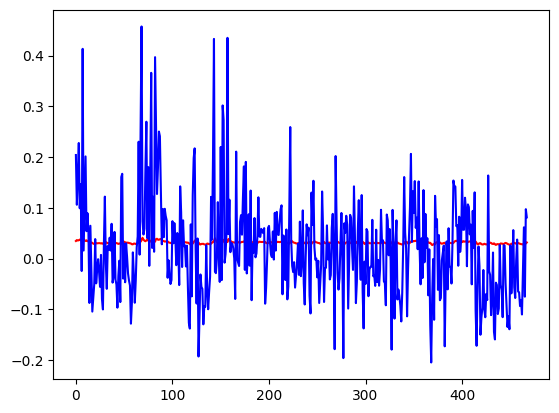

Epoch: 2/50 | Loss: 1.3573907588142902
Epoch: 2/50 | Evaluation_Loss: 4.245382990484629 | Pred. Power: 0.06465575700045878
Epoch: 3/50 | Loss: 1.236071358434856
Epoch: 3/50 | Evaluation_Loss: 3.8707632189376397 | Pred. Power: 0.1471921237506857
%---Saving the model---%
Epoch: 4/50 | Loss: 1.203855697880499
Epoch: 4/50 | Evaluation_Loss: 4.074997770149137 | Pred. Power: 0.10219509204041288
Epoch: 5/50 | Loss: 1.1701735645765439
Epoch: 5/50 | Evaluation_Loss: 3.8997609816024283 | Pred. Power: 0.14080331982369476
Epoch: 6/50 | Loss: 1.1565133414696902
Epoch: 6/50 | Evaluation_Loss: 4.090402642335059 | Pred. Power: 0.09880108825687017


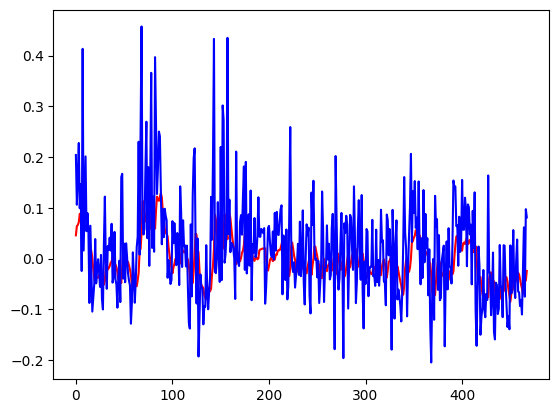

Epoch: 7/50 | Loss: 1.16388018312864
Epoch: 7/50 | Evaluation_Loss: 3.8681223418870196 | Pred. Power: 0.14777396353326788
%---Saving the model---%
Epoch: 8/50 | Loss: 1.15508222556673
Epoch: 8/50 | Evaluation_Loss: 3.8732756280515397 | Pred. Power: 0.14663857612092313
Epoch: 9/50 | Loss: 1.1591794387204573
Epoch: 9/50 | Evaluation_Loss: 3.881617923057376 | Pred. Power: 0.14480060952495055
Epoch: 10/50 | Loss: 1.145293360692449
Epoch: 10/50 | Evaluation_Loss: 3.9592835473491883 | Pred. Power: 0.12768928884687047
Epoch: 11/50 | Loss: 1.1438085902482271
Epoch: 11/50 | Evaluation_Loss: 3.9249793960789923 | Pred. Power: 0.13524719677101327


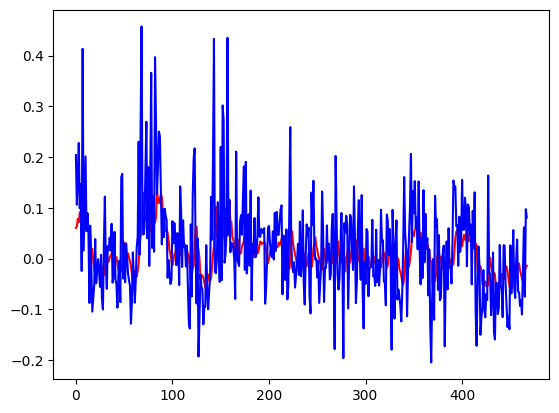

Epoch: 12/50 | Loss: 1.141040122602135
Epoch: 12/50 | Evaluation_Loss: 3.911189755850387 | Pred. Power: 0.13828533118951836
Epoch: 13/50 | Loss: 1.1452182255452499
Epoch: 13/50 | Evaluation_Loss: 3.8990451469682705 | Pred. Power: 0.1409610255299344
Epoch: 14/50 | Loss: 1.1354438921553083
Epoch: 14/50 | Evaluation_Loss: 4.012826749344626 | Pred. Power: 0.11589263159830376
Epoch: 15/50 | Loss: 1.1332450500922278
Epoch: 15/50 | Evaluation_Loss: 3.9165095190065466 | Pred. Power: 0.13711328679691848
Epoch: 16/50 | Loss: 1.1476240322226658
Epoch: 16/50 | Evaluation_Loss: 3.9588585598577573 | Pred. Power: 0.12778292489927368


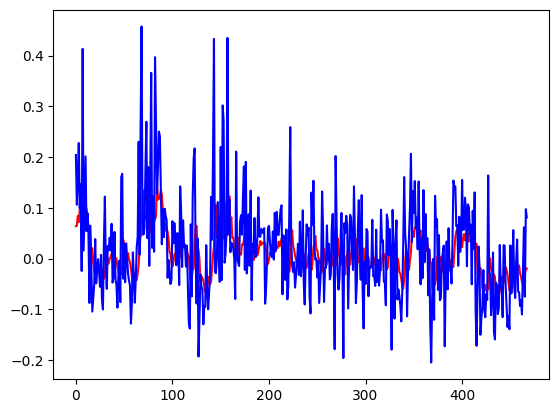

Epoch: 17/50 | Loss: 1.129634654847905
Epoch: 17/50 | Evaluation_Loss: 3.905456368083277 | Pred. Power: 0.1395485225970844
Epoch: 18/50 | Loss: 1.1392700175056234
Epoch: 18/50 | Evaluation_Loss: 3.9027632760082636 | Pred. Power: 0.14014185841326798
Epoch: 19/50 | Loss: 1.1431934497086331
Epoch: 19/50 | Evaluation_Loss: 3.9664027907190835 | Pred. Power: 0.12612079142357002
Epoch: 20/50 | Loss: 1.1304967176401988
Epoch: 20/50 | Evaluation_Loss: 3.9507493338539277 | Pred. Power: 0.12956956023508537
Epoch: 21/50 | Loss: 1.136070668231696
Epoch: 21/50 | Evaluation_Loss: 3.975641657486271 | Pred. Power: 0.1240852675319124


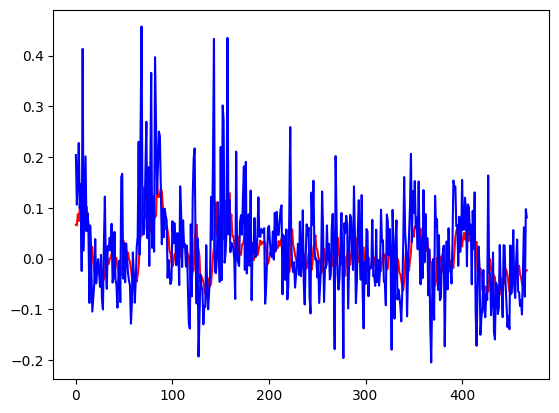

Epoch: 22/50 | Loss: 1.1320223265793175
Epoch: 22/50 | Evaluation_Loss: 3.9728182963894465 | Pred. Power: 0.12470731337303642
Epoch: 23/50 | Loss: 1.1351698167272843
Epoch: 23/50 | Evaluation_Loss: 3.9290440661988253 | Pred. Power: 0.1343516614512824
Epoch: 24/50 | Loss: 1.1319590234197676
Epoch: 24/50 | Evaluation_Loss: 3.9814021907612656 | Pred. Power: 0.12281609447818564
Epoch: 25/50 | Loss: 1.1312249368056655
Epoch: 25/50 | Evaluation_Loss: 3.9756472219568764 | Pred. Power: 0.12408403769174603
Epoch: 26/50 | Loss: 1.1300810064421967
Epoch: 26/50 | Evaluation_Loss: 3.920591210918935 | Pred. Power: 0.13621399760906883


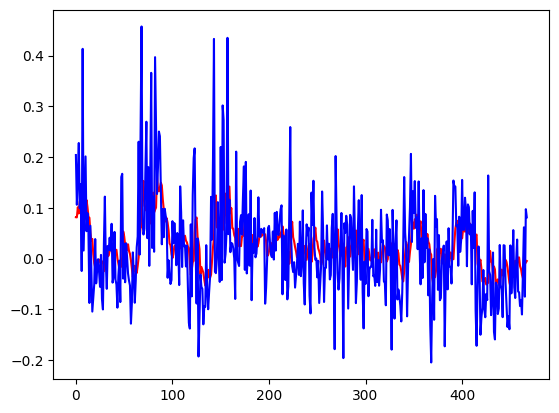

Epoch: 27/50 | Loss: 1.1350964882876724
Epoch: 27/50 | Evaluation_Loss: 3.9727041781845926 | Pred. Power: 0.12473246077606948
Epoch: 28/50 | Loss: 1.1321944063529372
Epoch: 28/50 | Evaluation_Loss: 3.9324241275847456 | Pred. Power: 0.133606971143021
Epoch: 29/50 | Loss: 1.1138461546506733
Epoch: 29/50 | Evaluation_Loss: 3.924369159348673 | Pred. Power: 0.135381637837925
Epoch: 30/50 | Loss: 1.1234888744074851
Epoch: 30/50 | Evaluation_Loss: 4.034059140523837 | Pred. Power: 0.11121471487735468
Epoch: 31/50 | Loss: 1.1285138627281412
Epoch: 31/50 | Evaluation_Loss: 4.013992814409587 | Pred. Power: 0.1156357250591098


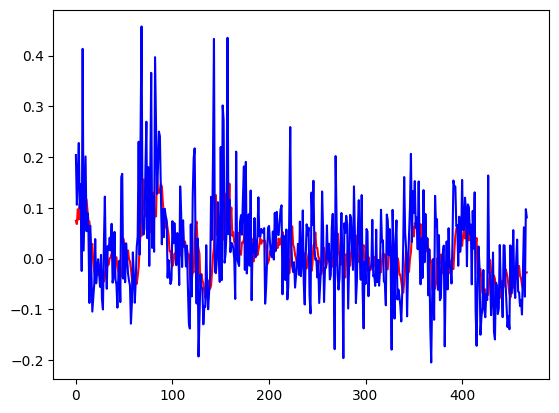

Epoch: 32/50 | Loss: 1.1271755791967735
Epoch: 32/50 | Evaluation_Loss: 3.9566073557101724 | Pred. Power: 0.1282789062436498
Epoch: 33/50 | Loss: 1.1255763701628894
Epoch: 33/50 | Evaluation_Loss: 4.014946501704543 | Pred. Power: 0.11542561342523971
Epoch: 34/50 | Loss: 1.1334271891973913
Epoch: 34/50 | Evaluation_Loss: 3.9638787527453587 | Pred. Power: 0.12667687550151985
Epoch: 35/50 | Loss: 1.1239877320476808
Epoch: 35/50 | Evaluation_Loss: 4.00993202918003 | Pred. Power: 0.11653040359666511
Epoch: 36/50 | Loss: 1.1262936977436766
Epoch: 36/50 | Evaluation_Loss: 3.946860598257755 | Pred. Power: 0.13042632409425015


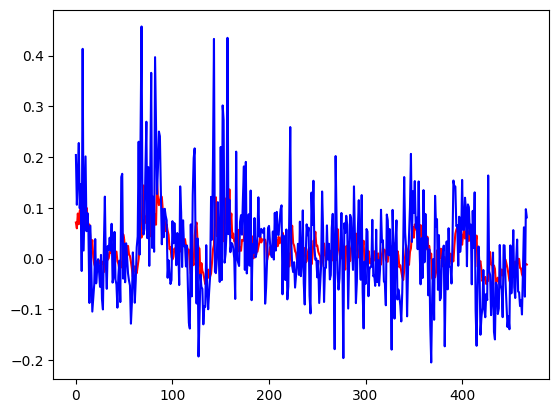

Epoch: 37/50 | Loss: 1.1183986673131585
Epoch: 37/50 | Evaluation_Loss: 3.9193288637576007 | Pred. Power: 0.13649210732195127
Epoch: 38/50 | Loss: 1.119871843373403
Epoch: 38/50 | Evaluation_Loss: 3.927402626953958 | Pred. Power: 0.13471330281338711
Epoch: 39/50 | Loss: 1.1171259930124506
Epoch: 39/50 | Evaluation_Loss: 4.004168223822284 | Pred. Power: 0.1178002819756856
Epoch: 40/50 | Loss: 1.119266412802972
Epoch: 41/50 | Loss: 1.113515631412156
Epoch: 41/50 | Evaluation_Loss: 3.9775148504497437 | Pred. Power: 0.12367257640858342


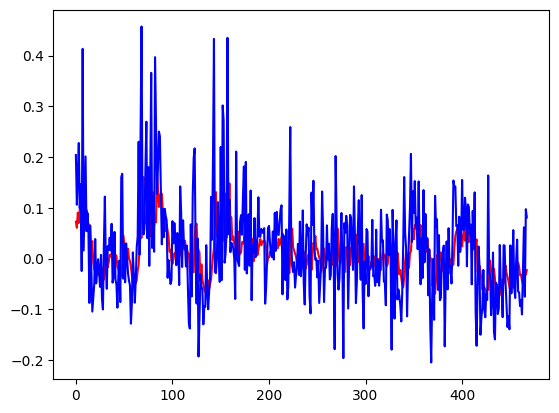

Epoch: 42/50 | Loss: 1.1110692512593232
Epoch: 42/50 | Evaluation_Loss: 3.9868921487428217 | Pred. Power: 0.12160655386486108
Epoch: 43/50 | Loss: 1.1101148502202705
Epoch: 43/50 | Evaluation_Loss: 3.9982280523715445 | Pred. Power: 0.11910902694725045
Epoch: 44/50 | Loss: 1.1082356594270095
Epoch: 44/50 | Evaluation_Loss: 3.965816367043942 | Pred. Power: 0.1262499742053924
Epoch: 45/50 | Loss: 1.11275932576973
Epoch: 45/50 | Evaluation_Loss: 3.938644419228482 | Pred. Power: 0.13223650619488647
Epoch: 46/50 | Loss: 1.1017015352845192
Epoch: 46/50 | Evaluation_Loss: 4.073412262671424 | Pred. Power: 0.10254441512328583


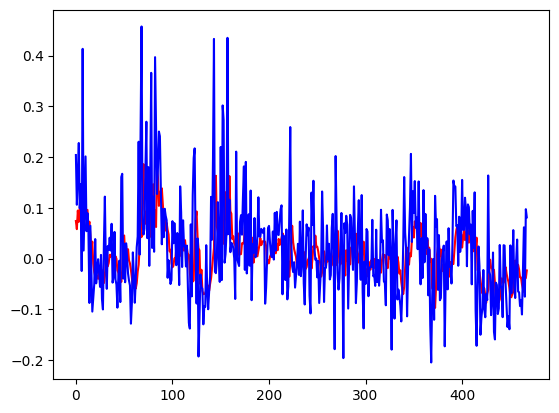

Epoch: 47/50 | Loss: 1.096391660219524
Epoch: 47/50 | Evaluation_Loss: 4.046243533015087 | Pred. Power: 0.10853023483147806
Epoch: 48/50 | Loss: 1.0960521107772365
Epoch: 48/50 | Evaluation_Loss: 3.985475574239513 | Pred. Power: 0.12191864407072239
Epoch: 49/50 | Loss: 1.0930424473481253
Epoch: 49/50 | Evaluation_Loss: 4.012489665225508 | Pred. Power: 0.11596689601114141
Epoch: 50/50 | Loss: 1.0902973717311397
Epoch: 50/50 | Evaluation_Loss: 4.075762254163038 | Pred. Power: 0.10202665964868252


In [27]:
train_valid_plot(train_loader2, val_loader2, 'model2_best.pth')

## Modify the encoder, decoder class for test

In [28]:
class EncoderRNN(nn.Module):
    def __init__(self,encoder_input_size=86,encoder_hidden_size=64, time_steps=10):
        super(EncoderRNN,self).__init__()
        self.input_size=encoder_input_size
        #input_size=n
        self.hidden_size=encoder_hidden_size
        #hidden_size=1
        self.t_steps=time_steps
        #time_steps=10

        self.input_attention=nn.Linear(time_steps+encoder_hidden_size,1)
        self.rnn=nn.GRU(self.input_size, self.hidden_size)

    def forward(self,encoder_input,batch_size):
        #encoder_input:batch,T,n
        encoder_input=encoder_input.permute(0,2,1) #batch,n,T
        #print (encoder_input.size())
        hidden=self.initHidden(batch_size) #hidden : 1,batch,hidden_size

        encoded = torch.zeros(batch_size, self.t_steps, self.hidden_size,device=device) #encoded: 1,T,hidden_size
        #print(encoded.size())
        for t in range(self.t_steps):
            x=torch.cat((hidden.repeat(self.input_size,1,1).permute(1,0,2),encoder_input),dim=2)
            #print (x.size())
            #x:batch,n,T+hidden_size
            x=x.view(-1,self.t_steps+self.hidden_size)
            #print (x.size())
            #x:batch*n,T+hidden_size
            x=F.softmax((self.input_attention(x)).view(-1,self.input_size),dim=1)
            #print (x.size())
            #print(encoder_input[:,t,:].size())
            #x:batch,n
            x=torch.mul(x,encoder_input[:,:,t])
            #print (x.size())
            #x:1,n
            output, hidden=self.rnn(x.unsqueeze(0), hidden)
            #print (output.size(), hidden.size())
            encoded[:,t,:]=hidden
            #output,hidden:1,1,hidden
        return encoded

    def initHidden(self,batch_size):
        return torch.zeros(1, batch_size, self.hidden_size, device=device)


class DecoderRNN(nn.Module):
    def __init__(self,decoder_hidden_size=64,encoder_hidden_size=64,decoder_input_size=1, time_steps=10):
        super(DecoderRNN,self).__init__()
        self.decoder_hidden_size=decoder_hidden_size
        self.encoder_hidden_size=encoder_hidden_size
        self.decoder_input_size=decoder_input_size
        self.t_steps=time_steps

        self.temporal_attention=nn.Linear(decoder_hidden_size+encoder_hidden_size, 1)
        self.rnn=nn.GRU(decoder_input_size,decoder_hidden_size)
        self.fc1 = nn.Linear(encoder_hidden_size + 1, 1)
        self.fc2 = nn.Linear(decoder_hidden_size + encoder_hidden_size, 1)

    def forward(self,encoded,y_history,batch_size):
        #encoded: batch,T,hidden_size
        #print (encoded.size())

        #y_history: batch,T-1
        hidden=self.initHidden(batch_size) #hidden:1,batch,hidden_size
        #print (hidden.size())
        for t in range(self.t_steps):
            x=torch.cat((hidden.repeat(self.t_steps,1,1).permute(1,0,2), encoded), dim=2)
            #x:batch,T,enc_hidden_size+dec_hidden_size
            x=F.softmax(self.temporal_attention(x.view(-1,self.decoder_hidden_size+self.encoder_hidden_size)).view(-1,self.t_steps), dim=1)
            #x:batch,T
            x=torch.bmm(x.unsqueeze(1), encoded)[:,0,:]
            #x:batch,hidden_size
            if (t < self.t_steps-1):
                y_tilda=self.fc1(torch.cat((x, y_history[:, t].unsqueeze(1)), dim=1))
                output, hidden=self.rnn(y_tilda.unsqueeze(0), hidden)
        y_pred=self.fc2(torch.cat((hidden[0], x), dim = 1))

        return y_pred


    def initHidden(self,batch_size):
        return torch.zeros(1, batch_size, self.decoder_hidden_size, device=device)


In [29]:
def test(encoder,decoder, test_loader, loss_criterion):
    eval_loss=0
    y_predicted=[]
    y_actual=[]
    with torch.no_grad():
        for i,sample in enumerate(test_loader):
            x=Variable(sample['X'].type(torch.cuda.FloatTensor))
            y=Variable(sample['targets'].type(torch.cuda.FloatTensor))
            y_true=Variable(sample['y'].type(torch.cuda.FloatTensor))
            encoded=encoder(x,1)
            y_pred=decoder(encoded,y,1)

            loss=loss_criterion(y_pred,y_true)
            eval_loss+=loss.item()
            y_predicted.append(y_pred.item())
            y_actual.append(y_true.item())

    return eval_loss, y_predicted, y_actual

## Check the two model's performance on the test set.

- Observe that the encoder-decoder model is better at predicting the next month's return compared to the current month's return, suggesting that the company financial data and headline sentiment data could have a delayed effect on the stock return. 
- The encoder-decoder model achieve R^2: 0.135621065548171  on predicting the next month's return, greatly outperforms the baseline xgboost mode (R2=0.07871246264624487).
- The encoder-decoder model achieve R^2: 0.14777396353326788 on predicting the next month's return, slightly outperform the baseline xgboost model (R2=0.1394458499720307).


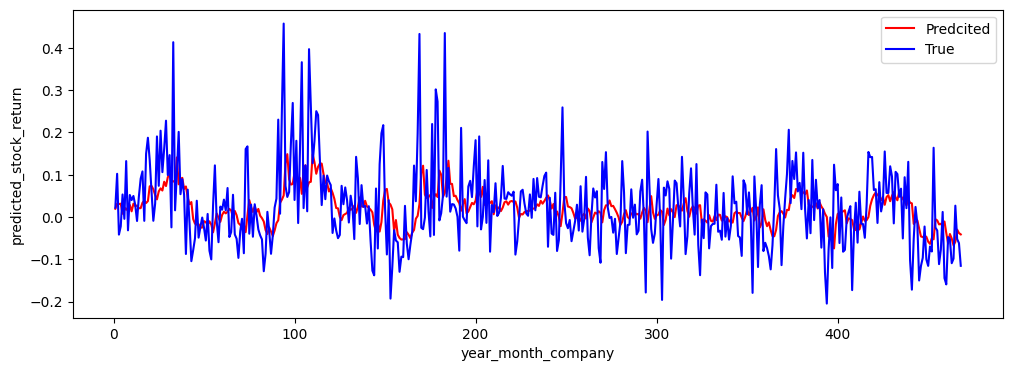

Task1: predict this month's return return | R^2: 0.135621065548171 | MSE Loss: 3.8708451440799987


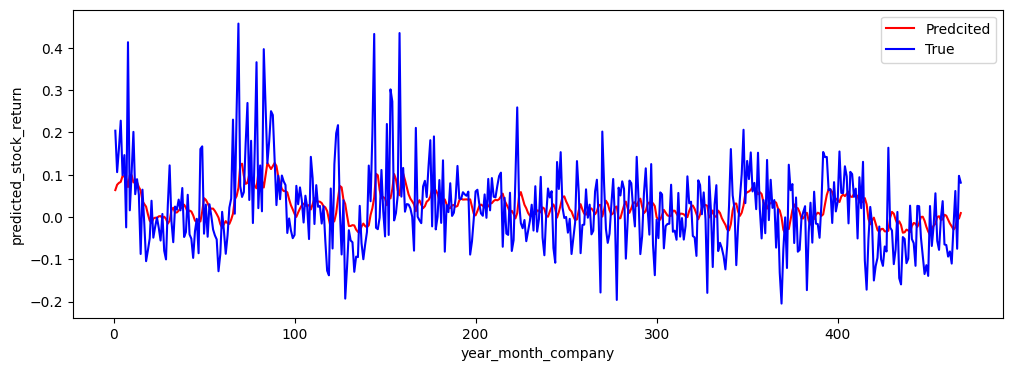

Task2: predict next month's return return | R^2: 0.14777396353326788 | MSE Loss: 3.8681223418870196


In [33]:

def test_result(model_path, test_loader, task_name):
  encoder=EncoderRNN().cuda()
  decoder = DecoderRNN().cuda()


  encoder_optimizer = optim.Adam(encoder.parameters())
  decoder_optimizer = optim.Adam(decoder.parameters())
  criterion=nn.MSELoss()

  checkpoint = torch.load(f'drive/MyDrive/stock/models/stockPrice/{model_path}')
  encoder.load_state_dict(checkpoint['encoder_state_dict'])
  decoder.load_state_dict(checkpoint['decoder_state_dict'])
  encoder_optimizer.load_state_dict(checkpoint['encoder_optimizer_state_dict'])
  decoder_optimizer.load_state_dict(checkpoint['decoder_optimizer_state_dict'])
  encoder.eval()
  decoder.eval()

  eval_loss,y_pred,y_true=test(encoder,decoder, test_loader, criterion)
  pred_perf=pp(y_pred,y_true)


  plt.figure(figsize=(12,4))
  plt.plot(range(1,len(y_pred)+1),y_pred,color='red',label='Predcited')
  plt.plot(range(1,len(y_true)+1),y_true,color='blue',label='True')
  plt.ylabel('predicted_stock_return')
  plt.xlabel('year_month_company')
  plt.legend()
  plt.show()
  print ('{} return | R^2: {} | MSE Loss: {}'.format(task_name, pred_perf, eval_loss))


test_result('model1_best.pth', test_loader, "Task1: predict this month's return")
test_result('model2_best.pth', test_loader2, "Task2: predict next month's return")


## Summary:
Overall, predicting stock returns using machine learning is a complex and challenging task that requires careful consideration of various factors and the use of advanced modeling techniques.

The task is challenging because: 

- Stock prices are influenced by a wide range of factors, including economic indicators, company performance, market sentiment, and geopolitical events. It is challenging to capture all its nuances and intricacies in a single machine learning models.

- Stock prices can be highly volatile and subject to sudden and unexpected changes, making it difficult to accurately predict future movements. The model tends to overfit to past data and fails to generalize.

- Historical stock price data may not be a reliable indicator of future performance, as market conditions and investor behavior can change over time.

- Stock prices are influenced by human emotions and irrational behavior (indicated by news headline and sentiment score), the measurement of which are difficult to quantify and incorporate into a machine learning model.